In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words=open("names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [31]:
#Building vocabulary of the characters
chars=sorted(list(set("".join(words))))
stoi={ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos={ch:i for i,ch in stoi.items()}

In [32]:
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [33]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [35]:
#Build the dataset
block_size=3     #how many characters required to predict the next character
X,Y=[],[]
for w in words[:3]:
    print(w)
    context=[0] *block_size
    print(context)
    for ch in w+'.':
        ix=stoi[ch]
        print(ix)
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context),'---->',itos[ix])
        context=context[1:]+[ix]

X=torch.tensor(X)
Y=torch.tensor(Y)

emma
[0, 0, 0]
5
... ----> e
13
..e ----> m
13
.em ----> m
1
emm ----> a
0
mma ----> .
olivia
[0, 0, 0]
15
... ----> o
12
..o ----> l
9
.ol ----> i
22
oli ----> v
9
liv ----> i
1
ivi ----> a
0
via ----> .
ava
[0, 0, 0]
1
... ----> a
22
..a ----> v
1
.av ----> a
0
ava ----> .


In [36]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

In [37]:
C=torch.randn((27,2))


In [38]:
emb=C[X]
emb.shape

torch.Size([16, 3, 2])

In [43]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([16, 6])

In [47]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([16, 6])

In [48]:
W1=torch.randn((6,100))
b1=torch.randn(100)

In [52]:
h=torch.tanh(emb.view(-1,6) @ W1+b1)
h.shape

torch.Size([16, 100])

In [53]:
W2=torch.randn((100,27))
b2=torch.randn(27)

In [55]:
logits=h @ W2 + b2
logits.shape

torch.Size([16, 27])

In [56]:
counts=logits.exp()

In [57]:
prob=counts/counts.sum(1,keepdims=True)

In [59]:
prob.shape

torch.Size([16, 27])

In [64]:
Y.shape


torch.Size([16])

In [68]:
loss=-prob[torch.arange(16),Y].log().mean()

In [69]:
loss

tensor(14.6036)

In [76]:
emb=C[X]
h=torch.tanh(emb.view(-1,6)@W1+b1)
logits=h@W2+b2
counts=logits.exp()
prob=counts/counts.sum(1,keepdims=True)
loss=-prob[torch.arange(16),Y].log().mean()
loss

tensor(20.2417)

In [77]:
F.cross_entropy(logits,Y)

tensor(20.2417)

In [101]:
#Build the dataset
block_size=3     #how many characters required to predict the next character
X,Y=[],[]
for w in words:
    #print(w)
    context=[0] *block_size
    #print(context)
    for ch in w+'.':
        ix=stoi[ch]
        #print(ix)
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context),'---->',itos[ix])
        context=context[1:]+[ix]

X=torch.tensor(X)
Y=torch.tensor(Y)

In [102]:
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,2),generator=g)
W1=torch.randn((6,100),generator=g)
b1=torch.randn(100,generator=g)
W2=torch.randn((100,27),generator=g)
b2=torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [103]:
sum(p.nelement() for p in parameters)   #number of parameters in total

3481

In [104]:
for p in parameters:
    p.requires_grad=True

In [105]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [106]:
lri=[]
lossi=[]
for i in range(1000):
    #Mini-Batch construct
    ix=torch.randint(0,X.shape[0],(32,))
    #forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1,6)@W1+b1)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,Y[ix])
    
    

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    lr=lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad

#track stats
    lri.append(lr)
    lossi.append(loss.item())




In [107]:
print(lri)

[tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0010), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0011), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0013), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0014), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(0.0015), tensor(

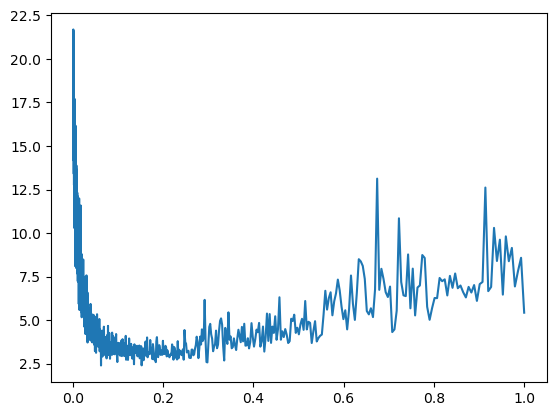

In [108]:
import matplotlib.pyplot as plt
plt.plot(lri,lossi)

In [109]:

for i in range(10000):
    #Mini-Batch construct
    ix=torch.randint(0,X.shape[0],(32,))
    #forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1,6)@W1+b1)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,Y[ix])
    
    

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    #lr=lrs[i]
    for p in parameters:
        p.data+=-0.05*p.grad

# #track stats
#     lri.append(lr)
#     lossi.append(loss.item())


In [170]:
def build_dataset(words):
    block_size=3
    X, Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [171]:
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,10),generator=g)
W1=torch.randn((30,200),generator=g)
b1=torch.randn(200,generator=g)
W2=torch.randn((200,27),generator=g)
b2=torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [172]:
for p in parameters:
    p.requires_grad=True

In [173]:
lossi=[]
stepi=[]
for i in range(10000):
    #Mini-Batch construct
    ix=torch.randint(0,Xtr.shape[0],(32,))
    #forward pass
    emb=C[Xtr[ix]]
    h=torch.tanh(emb.view(-1,30)@W1+b1)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,Ytr[ix])
    
    

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    #lr=lrs[i]
    for p in parameters:
        p.data+=-0.01*p.grad

# #track stats
#     lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())



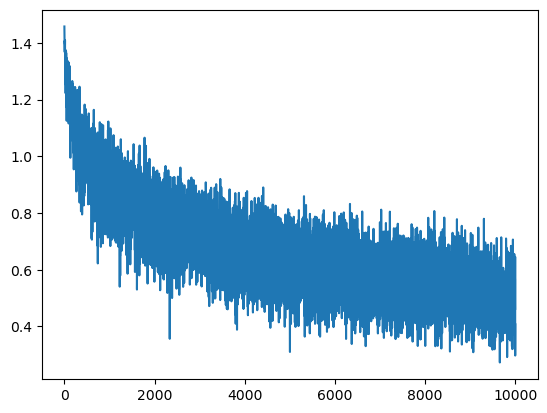

In [174]:
plt.plot(stepi,lossi)

In [175]:
print(loss.item())

2.554121255874634


In [176]:
emb=C[Xdev]
h=torch.tanh(emb.view(-1,30)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits,Ydev)
loss

tensor(3.3186, grad_fn=<NllLossBackward0>)

In [177]:
emb=C[Xte]
h=torch.tanh(emb.view(-1,30)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits,Yte)
loss

tensor(3.3355, grad_fn=<NllLossBackward0>)

In [178]:
emb=C[Xtr]
h=torch.tanh(emb.view(-1,30)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits,Ytr)
loss

tensor(3.3195, grad_fn=<NllLossBackward0>)

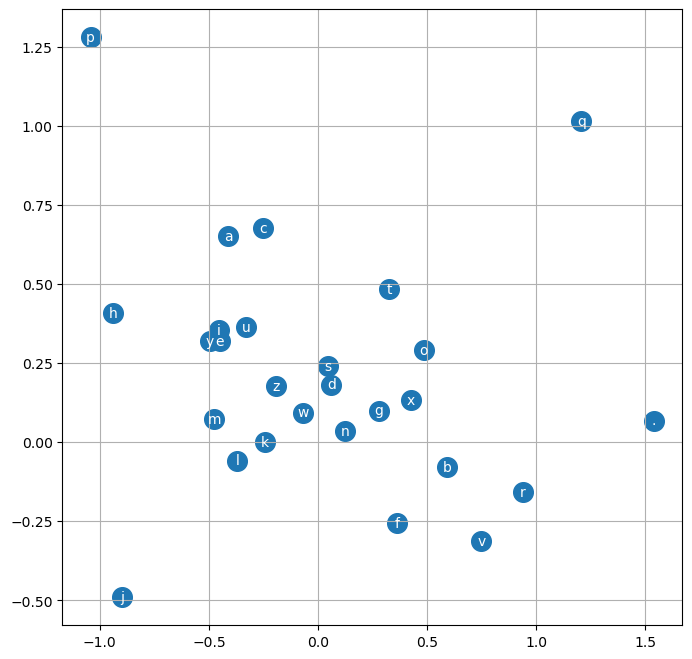

In [179]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",color="white")
plt.grid('minor')

In [ ]:
g=torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1))@W1+b1
        logits=h@W2+b2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print("".join([itos[i] for i in out]))
